# 🔐 Styling

In [29]:
%%HTML
<style>
body {
    --vscode-font-family : 'Nasalization';
}

.dataframe {
    font-family : 'Futura';
    # font-family : 'Century Gothic';
    border : 2px solid #252422;
    border-radius : 5px;
    overflow : hidden;
}

.dataframe tr th {
    text-align : center;
}

.dataframe td {
    paddign : 10px;
    text-align : left;
}

.dataframe tr:hover{
    background-color : #ef233c;
}

</style>

# 🛳️ Importation

In [30]:
import calendar
import datetime as dt

import psycopg2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from ipywidgets import widgets, interact

# 🎯 Main

## 📍 Collect data

In [31]:
# Create database connection

conn = ''

try :
    conn = psycopg2.connect(
        host = "localhost",
        port = "5432",
        user = "postgres",
        password = "postgres",
        dbname = "BudgetManagement"
    )    

except Exception as e: 
    print(e)

# Connect to Database and get informations
cursor = conn.cursor()

In [32]:
query = '''
SELECT * FROM target
WHERE montant IS NOT NULL
'''
cursor.execute(query)

colnames = [col.name for col in cursor.description]
rows = cursor.fetchall()

target = pd.DataFrame(columns=colnames, data=rows)
target

,id_categorie,cat_id_categorie,name_categorie,montant
0,1,NaN,Courses,100.00000
1,60,5.0,Streaming,14.00000
2,64,6.0,Carburant,150.00000
3,66,6.0,Assurance véhicule,130.00000
4,69,6.0,Autoroute,25.00000
5,77,7.0,Loyer,390.00000
6,87,9.0,Restauration,100.00000
7,88,9.0,Cantine,100.00000
8,97,10.0,Bancaire,130.00000
9,110,16.0,Don,10.00000


In [33]:
query = 'SELECT * FROM vue_Flux'
cursor.execute(query)

colnames = [col.name for col in cursor.description]
rows = cursor.fetchall()

data = pd.DataFrame(columns=colnames, data=rows)
data.head()

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
0,1,Entreprise,Sortie,Variable,Epargne,Livret A,2024-09-02,350.00000,#Epargne,Epargne août et réserve
1,2,Entreprise,Sortie,Variable,Divertissement,Brasserie,2024-09-02,9.00000,#Soirée,Soirée inté ENSIMAG
2,3,Entreprise,Entrée,Fixe,Emploi,Salaire,2024-09-02,1329.00000,#Salaire,Salaire août
3,4,Entreprise,Sortie,Fixe,Logement,Loyer,2024-09-02,390.00000,#Loyer,Loyer septembre 2024
4,5,Entreprise,Sortie,Exceptionnel,Impôts,Impôts,2024-09-03,103.00000,#Ecole,CVEC pour IUT


## 📍 Process

In [34]:
target = target.iloc[:, -2:]
target['montant'] = target['montant'].astype('float')

In [35]:
data['Date'] = pd.to_datetime(data['Date'])
data['Montant'] = data['Montant'].astype('float')

## 📍 Filter data

In [36]:
def get_month_end_date(date) :
    date = pd.to_datetime(date)
    month_end_day = calendar.monthrange(date.year, date.month)[1]
    month_end = date.replace(day=month_end_day)
    return month_end

In [37]:
# Relative dates from today
today = dt.datetime.today()
today = dt.datetime.combine(dt.datetime.today().date(), dt.time.min)

week_start = today - dt.timedelta(today.weekday())
week_end = week_start + dt.timedelta(days=6)

month_start = today.replace(day=1)
month_end = get_month_end_date(month_start)

# Specific dates
custom_start = dt.datetime(2025, 6, 1).date()
custom_end = dt.datetime(2025, 6, 15).date()
custom_month_end = get_month_end_date(custom_start)

## 📍 Calendar

In [38]:
dim_calendar_start = data.Date.min()
dim_calendar_start = dim_calendar_start.replace(month=1, day=1)

dim_calendar_end = data.Date.max()
dim_calendar_end = dim_calendar_end.replace(month=12, day=31)

dim_calendar = pd.date_range(start=dim_calendar_start, end=dim_calendar_end)
dim_calendar = pd.DataFrame(dim_calendar, columns=['Date'])

# Add features
dim_calendar['Annee'] = dim_calendar['Date'].dt.year
dim_calendar['Month'] = dim_calendar['Date'].dt.month
dim_calendar['Month Name'] = dim_calendar['Date'].dt.month_name()
dim_calendar['Week'] = dim_calendar['Date'].dt.isocalendar().week.astype('int32')

dim_calendar['Date'] = dim_calendar['Date']
dim_calendar['Annee'] = dim_calendar['Annee'].astype('str')
dim_calendar['Month'] = dim_calendar['Month'].astype('str').str.zfill(2)
dim_calendar['Week'] = dim_calendar['Week'].astype('str').str.zfill(2)

dim_calendar

,Date,Annee,Month,Month Name,Week
0,2024-01-01,2024,01,January,01
1,2024-01-02,2024,01,January,01
2,2024-01-03,2024,01,January,01
3,2024-01-04,2024,01,January,01
4,2024-01-05,2024,01,January,01
...,...,...,...,...,...
726,2025-12-27,2025,12,December,52
727,2025-12-28,2025,12,December,52
728,2025-12-29,2025,12,December,01
729,2025-12-30,2025,12,December,01


# 🎭 Visualisation

## 📋 Besoins

- Dimensions :
    - ✅ Temps
    - Catégorie
    - Sous-Catégorie

- Mesures :
    - ✅ Entrée
    - ✅ Sortie
    - ✅ Disponible
    - ✅ Entrée en Epargne
    - ✅ Sortie en Epargne
    - ✅ Epargné

- Visuels : 
    - 📜 Page N°1 :
        - Vignettes des mesures
        - ✅ Sortie par Catégorie
        - ❌ Graphique en camembert pour les top 5 dépenses
        - ✅ Dépenses sur le temps avec une hue = 'Période'

    - 📜 Page N°2 :
        - ✅ Sortie par Catégorie, Sous-Catégorie
        - ✅ Tableau des dépenses
    
    - 📜 Page N°3 :
        - ✅ Entrée par temps
        - ✅ Sortie par temps

    - 📜 Page N°4 :
        - Visuels target

## 🎨 Couleurs

In [39]:
custom_colors_palette = [
    [
        '#F72585',
        '#7209B7',
        '#3A0CA3',
        '#4361EE',
        '#4CC9F0',
    ],

    [
        '#390099',
        '#9E0059',
        '#FF0054',
        '#FF5400',
        '#FFBD00',
    ],

    [
        '#ff9f1c',
        '#ffbf69',
        '#ffffff',
        '#cbf3f0',
        '#2ec4b6',
    ],

    [
        '#22162b',
        '#451f55',
        '#724e91',
        '#e54f6d',
        '#f8c630',
    ],
        
    [
        '#5465ff',
        '#788bff',
        '#9bb1ff',
        '#bfd7ff',
        '#e2fdff',
    ],
]

In [40]:
custom_colors_palette = [
    '#F72585',
    '#7209B7',
    '#3A0CA3',
    '#4361EE',
    '#4CC9F0',

    '#390099',
    '#9E0059',
    '#FF0054',
    '#FF5400',
    '#FFBD00',

    '#ff9f1c',
    '#ffbf69',
    '#ffffff',
    '#cbf3f0',
    '#2ec4b6',

    '#22162b',
    '#451f55',
    '#724e91',
    '#e54f6d',
    '#f8c630',

    '#5465ff',
    '#788bff',
    '#9bb1ff',
    '#bfd7ff',
    '#bfd7ff',
]

In [41]:
custom_colors_palette_display = sns.palettes.color_palette(custom_colors_palette)
custom_colors_palette_display

[(0.9686274509803922, 0.1450980392156863, 0.5215686274509804),
 (0.4470588235294118, 0.03529411764705882, 0.7176470588235294),
 (0.22745098039215686, 0.047058823529411764, 0.6392156862745098),
 (0.2627450980392157, 0.3803921568627451, 0.9333333333333333),
 (0.2980392156862745, 0.788235294117647, 0.9411764705882353),
 (0.2235294117647059, 0.0, 0.6),
 (0.6196078431372549, 0.0, 0.34901960784313724),
 (1.0, 0.0, 0.32941176470588235),
 (1.0, 0.32941176470588235, 0.0),
 (1.0, 0.7411764705882353, 0.0),
 (1.0, 0.6235294117647059, 0.10980392156862745),
 (1.0, 0.7490196078431373, 0.4117647058823529),
 (1.0, 1.0, 1.0),
 (0.796078431372549, 0.9529411764705882, 0.9411764705882353),
 (0.1803921568627451, 0.7686274509803922, 0.7137254901960784),
 (0.13333333333333333, 0.08627450980392157, 0.16862745098039217),
 (0.27058823529411763, 0.12156862745098039, 0.3333333333333333),
 (0.4470588235294118, 0.3058823529411765, 0.5686274509803921),
 (0.8980392156862745, 0.30980392156862746, 0.42745098039215684),
 (0.9725490196078431, 0.7764705882352941, 0.18823529411764706),
 (0.32941176470588235, 0.396078431372549, 1.0),
 (0.47058823529411764, 0.5450980392156862, 1.0),
 (0.6078431372549019, 0.6941176470588235, 1.0),
 (0.7490196078431373, 0.8431372549019608, 1.0),
 (0.7490196078431373, 0.8431372549019608, 1.0)]

## 📐 Mesures

In [42]:
def calculate_entree(df) :
    result = df[df['Type de flux'] == 'Entrée']['Montant'].sum()
    return result

def calculate_sortie(df) :
    result = df[df['Type de flux'] == 'Sortie']['Montant'].sum()
    return result

def calculate_disponible(df) :
    return calculate_entree(df) - calculate_sortie(df)

def calculate_entree_depuis_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Entrée')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_sortie_en_epargne(df) :
    result = df[
            (df['Type de flux'] == 'Sortie')
        &   (df['Catégorie'] == 'Epargne')
    ]['Montant'].sum()
    return result

def calculate_epargne(df) :
    return calculate_entree_depuis_epargne(df) - calculate_sortie_en_epargne(df)

## 📕 Fonctions

### 📝 plot_flux_sur_le_temps

In [57]:
def plot_flux_sur_le_temps(donnees) :
    data_entree_sortie = donnees.copy()

    # Grouper les valeurs
    data_entree_sortie = data_entree_sortie.groupby(['Date', 'Période','Type de flux'])['Montant'].sum().reset_index()
    data_entree_sortie = data_entree_sortie.sort_values('Date')

    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= data_entree_sortie['Date'].min())
        &   (dim_calendar['Date'] <= get_month_end_date(donnees['Date'].min()))
    ]['Date']

    # Gestion des valeurs nulles
    data_entree_sortie = data_entree_sortie.merge(month_days_list, how='right')
    data_entree_sortie['Période'] = data_entree_sortie['Période'].fillna('---')
    data_entree_sortie['Type de flux'] = data_entree_sortie['Type de flux'].fillna('---')
    data_entree_sortie['Montant'] = data_entree_sortie['Montant'].fillna(0)

    # Ajout de couleurs
    dict_periode_couleur = {
        'Entreprise' : '#390099',
        'Ecole' : '#9E0059',
        'Vacances' : '#FF0054',
        '---' : '---'
    }

    dict_periode_couleur = dict(zip(data_entree_sortie['Période'].unique(), custom_colors_palette))
    data_entree_sortie['Couleur'] = data_entree_sortie['Période'].map(dict_periode_couleur)


    entree_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Entrée']
    sortie_data = data_entree_sortie[data_entree_sortie['Type de flux'] == 'Sortie']

    fig, ax = plt.subplots(figsize=(30, 5))

    plt.bar(sortie_data['Date'], sortie_data['Montant'], color=sortie_data['Couleur'])
    plt.scatter(entree_data['Date'], entree_data['Montant'], label='Entrée', color='#4CC9F0')

    ax.set_xticks(data_entree_sortie['Date'], data_entree_sortie['Date'].dt.date, rotation=90)

    handles = []
    for key, color in dict_periode_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.title('Entrée et Sortie sur le mois')
    plt.legend(handles=handles)
    plt.show()

### 📝 plot_depenses_par_categorie

In [44]:
def plot_depenses_par_categorie(donnees) : 
    sortie_categorie = donnees.copy()
    sortie_categorie = sortie_categorie[sortie_categorie['Type de flux'] == 'Sortie']
    sortie_categorie = sortie_categorie.groupby(['Catégorie'])['Montant'].sum().reset_index()
    sortie_categorie = sortie_categorie.sort_values('Montant', ascending=False)

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_categorie['Catégorie'], sortie_categorie['Montant'], color='#f8c630')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    plt.title('Dépenses par Catégorie')
    plt.yticks(np.arange(0, sortie_categorie['Montant'].max() * 1.2, 100))
    plt.show()

### 📝 plot_depenses_par_ss_categorie

In [45]:
def plot_depenses_par_ss_categorie(donnees, categories) :
    sortie_ss_categorie = donnees.copy()

    if len(categories) == 0 :
        categories = donnees['Catégorie'].unique()

    
    sortie_ss_categorie = sortie_ss_categorie[
            (sortie_ss_categorie['Type de flux'] == 'Sortie')
        &   (sortie_ss_categorie['Catégorie'].isin(categories))
    ]
    sortie_ss_categorie = sortie_ss_categorie.groupby(['Catégorie', 'Sous-catégorie'])['Montant'].sum().reset_index()
    sortie_ss_categorie = sortie_ss_categorie.sort_values(['Montant', 'Catégorie', 'Sous-catégorie'], ascending=False)

    dict_couleur = dict(zip(sortie_ss_categorie['Catégorie'].unique(), custom_colors_palette))
    sortie_ss_categorie['Couleur'] = sortie_ss_categorie['Catégorie'].map(dict_couleur)


    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(sortie_ss_categorie['Sous-catégorie'], sortie_ss_categorie['Montant'], color=sortie_ss_categorie['Couleur'])
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.2)

    handles = []
    for key, color in dict_couleur.items() :
        patch = mpatches.Patch(label=key, color=color)
        handles.append(patch)

    plt.title('Dépenses par Sous-Catégorie')
    # plt.yticks(np.arange(0, sortie_ss_categorie['Montant'].max() * 1.2, 100))
    plt.legend(handles = handles)
    plt.show()

### 📝 plot_entree_sur_temps

In [46]:
def plot_entree_sur_temps(donnees, period, month_end) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Entrée']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    if month_end is True :
        date_max = get_month_end_date(donnees['Date'].min())
    else :
        date_max = donnees['Date'].max()
        
    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= date_max)
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#2ec4b6')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Entrée sur le temps')
    plt.show()

### 📝 plot_depenses_sur_temps

In [47]:
def plot_depenses_sur_temps(donnees, period, month_end) :
    data = donnees.copy()
    data = data[data['Type de flux'] == 'Sortie']

    data_columns = ['Date', 'Type de flux', 'Période', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Montant']
    data_columns = ['Date', 'Montant']
    data = data[data_columns]

    if month_end is True :
        date_max = get_month_end_date(donnees['Date'].min())
    else :
        date_max = donnees['Date'].max()
        
    month_days_list = dim_calendar[
            (dim_calendar['Date'] >= donnees['Date'].min())
        &   (dim_calendar['Date'] <= date_max)
    ]['Date']


    data = data.merge(month_days_list, how='right')
    data = data.merge(dim_calendar, how='inner')

    data['Week_Format'] = 'W' + data['Week']
    data['Year-Month'] = data['Annee'] + '-' + data['Month']
    data['Year-Week'] = data['Annee'] + '-' + data['Week_Format']

    dict_groupby_columns = {
        'year' : 'Annee',
        'month' : 'Year-Month',
        'week' : 'Year-Week',
    }

    data = data.groupby(dict_groupby_columns[period])['Montant'].sum()
    data = data.reset_index()

    fig, ax = plt.subplots(figsize=(30, 5))

    bar = ax.bar(data[dict_groupby_columns[period]], data['Montant'], color='#ffbf69')
    ax.bar_label(bar, label_type='edge', color='#000000', padding=1.5)

    plt.title('Dépenses sur le temps')
    plt.show()

### 📝 plot_target_comparaison

In [48]:
def plot_target_comparaison(donnees) :
    target_comparaison = target.copy()
    target_comparaison


    depenses_reel_categorie = donnees.groupby(['Catégorie'])['Montant'].sum().reset_index()
    depenses_reel_categorie = depenses_reel_categorie.rename(columns={'Catégorie' : 'name_categorie'})

    depenses_reel_ss_categorie = donnees.groupby(['Sous-catégorie'])['Montant'].sum().reset_index()
    depenses_reel_ss_categorie = depenses_reel_ss_categorie.rename(columns={'Sous-catégorie' : 'name_categorie'})

    depenses_reel = pd.concat([depenses_reel_categorie, depenses_reel_ss_categorie])

    target_comparaison = target_comparaison.merge(depenses_reel, how='left').fillna(0)
    target_comparaison = target_comparaison.rename(columns={
        'name_categorie' : 'Catégorie',
        'montant' : 'Target',
        'Montant' : 'Réel',
    })

    target_comparaison['target_reached'] = np.where(target_comparaison['Réel'] >= target_comparaison['Target'], 'YES', 'NO')
    target_comparaison['difference'] = target_comparaison['Target'] - target_comparaison['Réel']

    target_comparaison['below'] = np.where(target_comparaison['target_reached'] == 'YES', target_comparaison['Target'], target_comparaison['Réel'])
    target_comparaison['above'] = np.abs(target_comparaison['difference'])

    target_comparaison['above_bar_color'] = np.where(target_comparaison['target_reached'] == 'YES', '#f72585', '#fca311')
    target_comparaison = target_comparaison.sort_values('Target', ascending=False)

    fig, ax = plt.subplots(figsize=(20, 5))

    # Line plot
    ax.plot(target_comparaison['Catégorie'], target_comparaison['Target'], linestyle='--', marker='o', color='#000000', label='Target')

    # Above bar
    p_above_bar = ax.bar(target_comparaison['Catégorie'], target_comparaison['above'], bottom=target_comparaison['below'], color=target_comparaison['above_bar_color'])
    ax.bar_label(p_above_bar, label_type='center', color='#FFFFFF')

    # Below
    p_below_bar = ax.bar(target_comparaison['Catégorie'], target_comparaison['below'], color='#4361ee')
    ax.bar_label(p_below_bar, label_type='center', color='#FFFFFF')

    # Plot settings
    plt.xticks(rotation=90, size=12)
    ax.set(yticks=np.arange(0, target_comparaison['Target'].max() * 1.2, 100))
    ax.grid(axis='y', color='#000000')
    ax.set_axisbelow(True)

    # Legend
    blue_bar = mpatches.Patch(color='#4361ee', label='Dépensé')
    pink_bar = mpatches.Patch(color='#f72585', label='Surplus')
    yellow_bar = mpatches.Patch(color='#fca311', label='Restant')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles + [blue_bar, pink_bar, yellow_bar])

    plt.title('Analyses des dépenses fixes')
    plt.show()

## 📜 Page N°1

In [49]:
# Définitions des filtres
page_1_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_1_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_1_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_1_filter_period_start = month_start
page_1_filter_period_end = month_end

page_1_filter_categorie = [

]
page_1_filter_ss_categorie = [

]

if len(page_1_filter_categorie) == 0 :
    page_1_filter_categorie = data['Catégorie'].unique()
if len(page_1_filter_ss_categorie) == 0 :
    page_1_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_1_data = data.copy()
page_1_data = page_1_data[
        (page_1_data['Période'].isin(page_1_filter_periode))
    &   (page_1_data['Type de flux'].isin(page_1_filter_type_flux))
    &   (page_1_data['Fixes'].isin(page_1_filter_fixes))
    &   (page_1_data['Date'] >= page_1_filter_period_start)
    &   (page_1_data['Date'] <= page_1_filter_period_end)
    &   (page_1_data['Catégorie'].isin(page_1_filter_categorie))
    &   (page_1_data['Sous-catégorie'].isin(page_1_filter_ss_categorie))
]

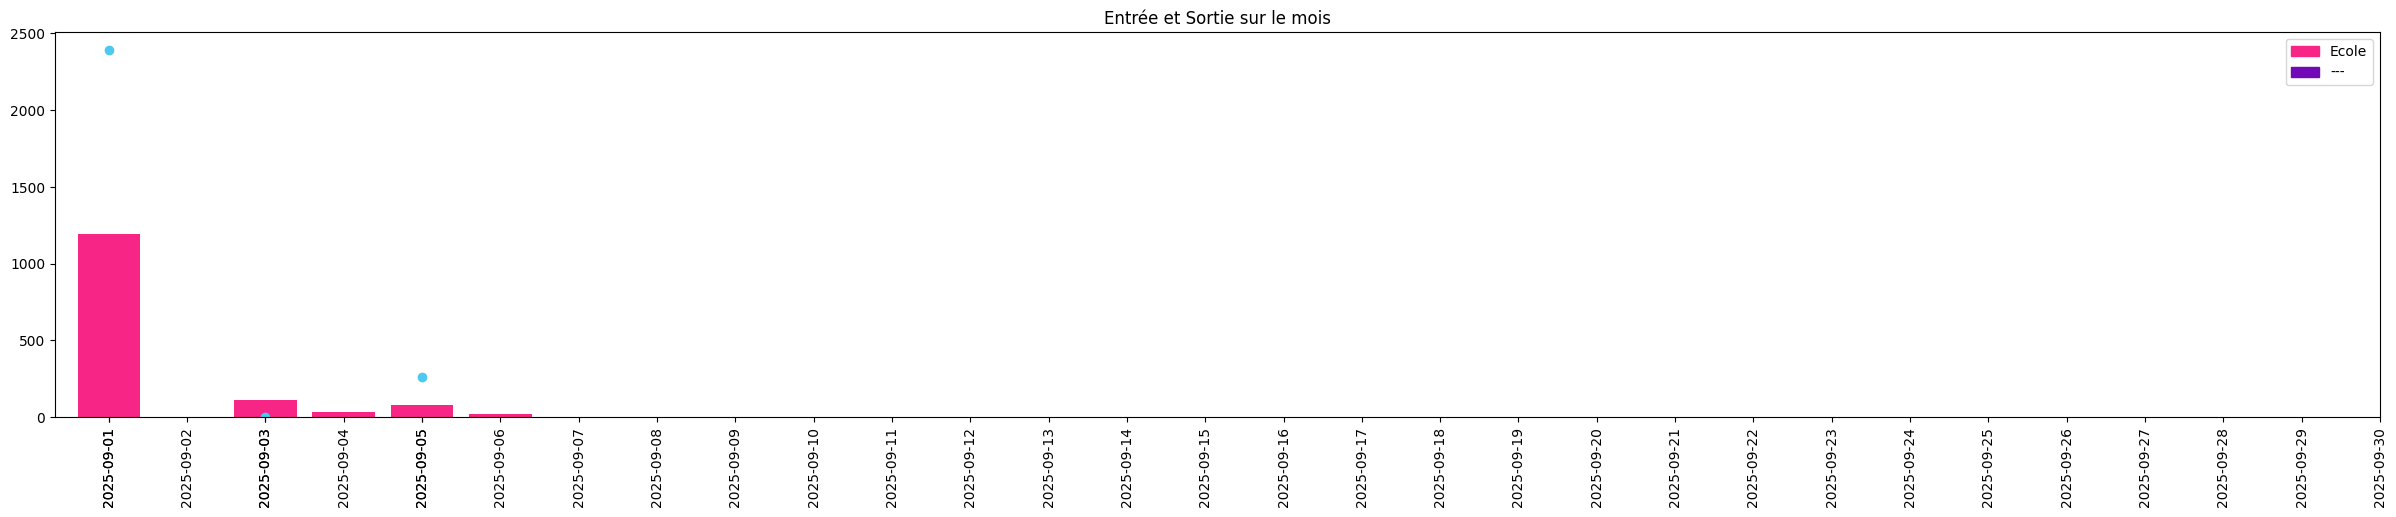

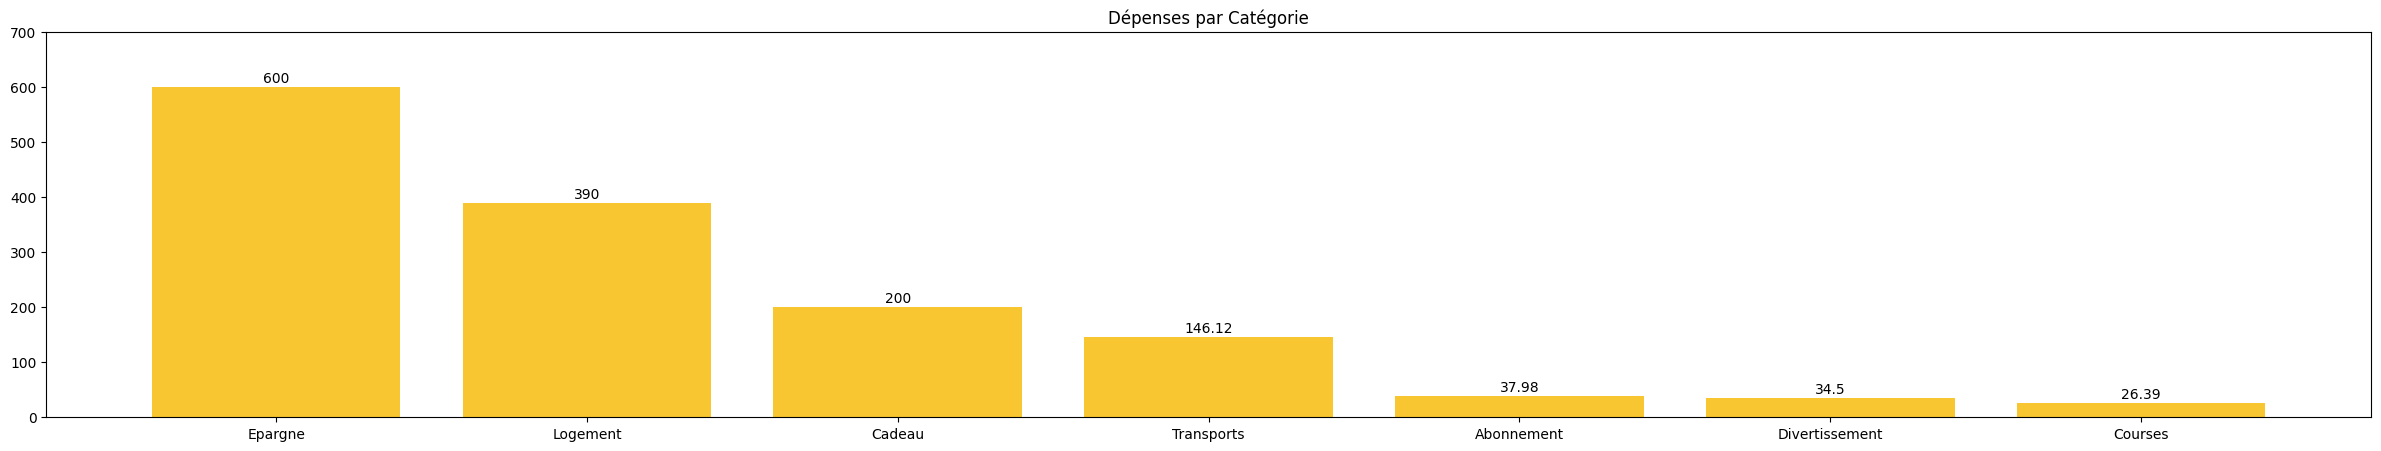

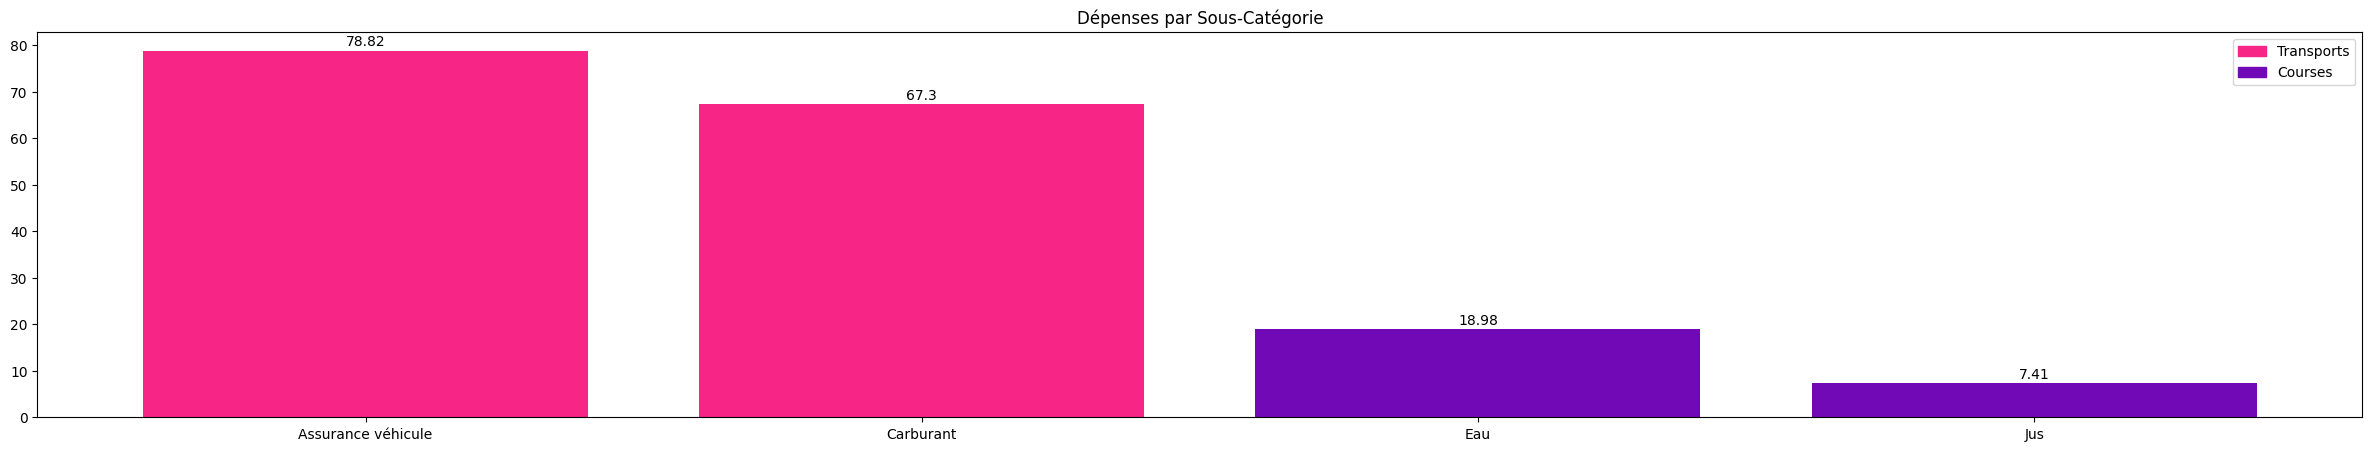

In [50]:
plot_flux_sur_le_temps(page_1_data)
plot_depenses_par_categorie(page_1_data)
plot_depenses_par_ss_categorie(page_1_data, ['Courses', 'Transports'])

## 📜 Page N°2

In [51]:
# Définitions des filtres
page_2_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_2_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_2_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_2_filter_period_start = month_start
page_2_filter_period_end = month_end

page_2_filter_categorie = [

]
page_2_filter_ss_categorie = [

]

if len(page_2_filter_categorie) == 0 :
    page_2_filter_categorie = data['Catégorie'].unique()
if len(page_2_filter_ss_categorie) == 0 :
    page_2_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_2_data = data.copy()
page_2_data = page_2_data[
        (page_2_data['Période'].isin(page_2_filter_periode))
    &   (page_2_data['Type de flux'].isin(page_2_filter_type_flux))
    &   (page_2_data['Fixes'].isin(page_2_filter_fixes))
    &   (page_2_data['Date'] >= page_2_filter_period_start)
    &   (page_2_data['Date'] <= page_2_filter_period_end)
    &   (page_2_data['Catégorie'].isin(page_2_filter_categorie))
    &   (page_2_data['Sous-catégorie'].isin(page_2_filter_ss_categorie))
]

page_2_data['Entrée'] = np.where(page_2_data['Type de flux'] == 'Entrée', page_2_data['Montant'], '---')
page_2_data['Sortie'] = np.where(page_2_data['Type de flux'] == 'Sortie', page_2_data['Montant'], '---')

page_2_columns = ['ID Flux', 'Date', 'Période', 'Type de flux', 'Fixes', 'Catégorie', 'Sous-catégorie', 'Entrée', 'Sortie', 'Description', 'Tags']

page_2_data[page_2_columns]

,ID Flux,Date,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Entrée,Sortie,Description,Tags
983,1032,2025-09-01,Ecole,Entrée,Fixe,Emploi,Salaire,2389.01,---,Dernier salaire contrat Tetras,#salaire
984,1033,2025-09-01,Ecole,Sortie,Fixe,Epargne,Livret A,---,400.0,Epargne début de mois,#epargne
985,1034,2025-09-01,Ecole,Sortie,Fixe,Cadeau,Famille,---,200.0,Cadeau papa et maman,#papa #maman
986,1035,2025-09-01,Ecole,Sortie,Fixe,Logement,Loyer,---,390.0,Loyer Septembre 2025,#loyer
987,1036,2025-09-01,Ecole,Sortie,Exceptionnel,Epargne,Revolut,---,200.0,Pour investir sur Etherum,#etherum
988,1037,2025-09-03,Ecole,Entrée,Variable,Emploi,Salaire,4.0,---,BlaBla car,#business
989,1038,2025-09-01,Ecole,Sortie,Fixe,Abonnement,Mobile,---,0.99,Apple ICloud,#icloud
990,1039,2025-09-03,Ecole,Sortie,Fixe,Abonnement,Streaming,---,14.99,Netflix,#netflix
991,1040,2025-09-03,Ecole,Sortie,Variable,Courses,Jus,---,7.41,Courses Hyper U Thoiry : Pulco etc.,#pulco
992,1041,2025-09-04,Ecole,Sortie,Variable,Divertissement,Brasserie,---,4.0,Sortie le Bowl avec IAE,#coca


In [52]:
flux_summary = [
    {'Description' : 'Entrée depuis epargne', 'Montant' : calculate_entree_depuis_epargne(page_2_data)},
    {'Description' : 'Sortie en epargne', 'Montant' : calculate_sortie_en_epargne(page_2_data)},
    {'Description' : 'Entree', 'Montant' : calculate_entree(page_2_data)},
    {'Description' : 'Sortie', 'Montant' : calculate_sortie(page_2_data)},
    {'Description' : 'Disponible', 'Montant' : calculate_disponible(page_2_data)},
]

pd.DataFrame(flux_summary)

,Description,Montant
0,Entrée depuis epargne,0.00
1,Sortie en epargne,600.00
2,Entree,2652.31
3,Sortie,1434.99
4,Disponible,1217.32


## 📜 Page N°3

In [53]:
# Définitions des filtres
page_3_filter_periode = [
    'Ecole',
    'Entreprise',
    'Vacances',
]

page_3_filter_type_flux = [
    'Entrée',
    'Neutre',
    'Réparation',
    'Sortie',
]

page_3_filter_fixes = [
    'Exceptionnel',
    'Fixe',
    'Variable',
]

page_3_filter_period_start = month_start
page_3_filter_period_end = month_end

page_3_filter_categorie = [

]
page_3_filter_ss_categorie = [

]

if len(page_3_filter_categorie) == 0 :
    page_3_filter_categorie = data['Catégorie'].unique()
if len(page_3_filter_ss_categorie) == 0 :
    page_3_filter_ss_categorie = data['Sous-catégorie'].unique()

# Extracttion de données filtrées
page_3_data = data.copy()
page_3_data = page_3_data[
        (page_3_data['Période'].isin(page_3_filter_periode))
    &   (page_3_data['Type de flux'].isin(page_3_filter_type_flux))
    &   (page_3_data['Fixes'].isin(page_3_filter_fixes))
    &   (page_3_data['Date'] >= page_3_filter_period_start)
    &   (page_3_data['Date'] <= page_3_filter_period_end)
    &   (page_3_data['Catégorie'].isin(page_3_filter_categorie))
    &   (page_3_data['Sous-catégorie'].isin(page_3_filter_ss_categorie))
]
page_3_data

,ID Flux,Période,Type de flux,Fixes,Catégorie,Sous-catégorie,Date,Montant,Tags,Description
983,1032,Ecole,Entrée,Fixe,Emploi,Salaire,2025-09-01,2389.01,#salaire,Dernier salaire contrat Tetras
984,1033,Ecole,Sortie,Fixe,Epargne,Livret A,2025-09-01,400.00,#epargne,Epargne début de mois
985,1034,Ecole,Sortie,Fixe,Cadeau,Famille,2025-09-01,200.00,#papa #maman,Cadeau papa et maman
986,1035,Ecole,Sortie,Fixe,Logement,Loyer,2025-09-01,390.00,#loyer,Loyer Septembre 2025
987,1036,Ecole,Sortie,Exceptionnel,Epargne,Revolut,2025-09-01,200.00,#etherum,Pour investir sur Etherum
988,1037,Ecole,Entrée,Variable,Emploi,Salaire,2025-09-03,4.00,#business,BlaBla car
989,1038,Ecole,Sortie,Fixe,Abonnement,Mobile,2025-09-01,0.99,#icloud,Apple ICloud
990,1039,Ecole,Sortie,Fixe,Abonnement,Streaming,2025-09-03,14.99,#netflix,Netflix
991,1040,Ecole,Sortie,Variable,Courses,Jus,2025-09-03,7.41,#pulco,Courses Hyper U Thoiry : Pulco etc.
992,1041,Ecole,Sortie,Variable,Divertissement,Brasserie,2025-09-04,4.00,#coca,Sortie le Bowl avec IAE


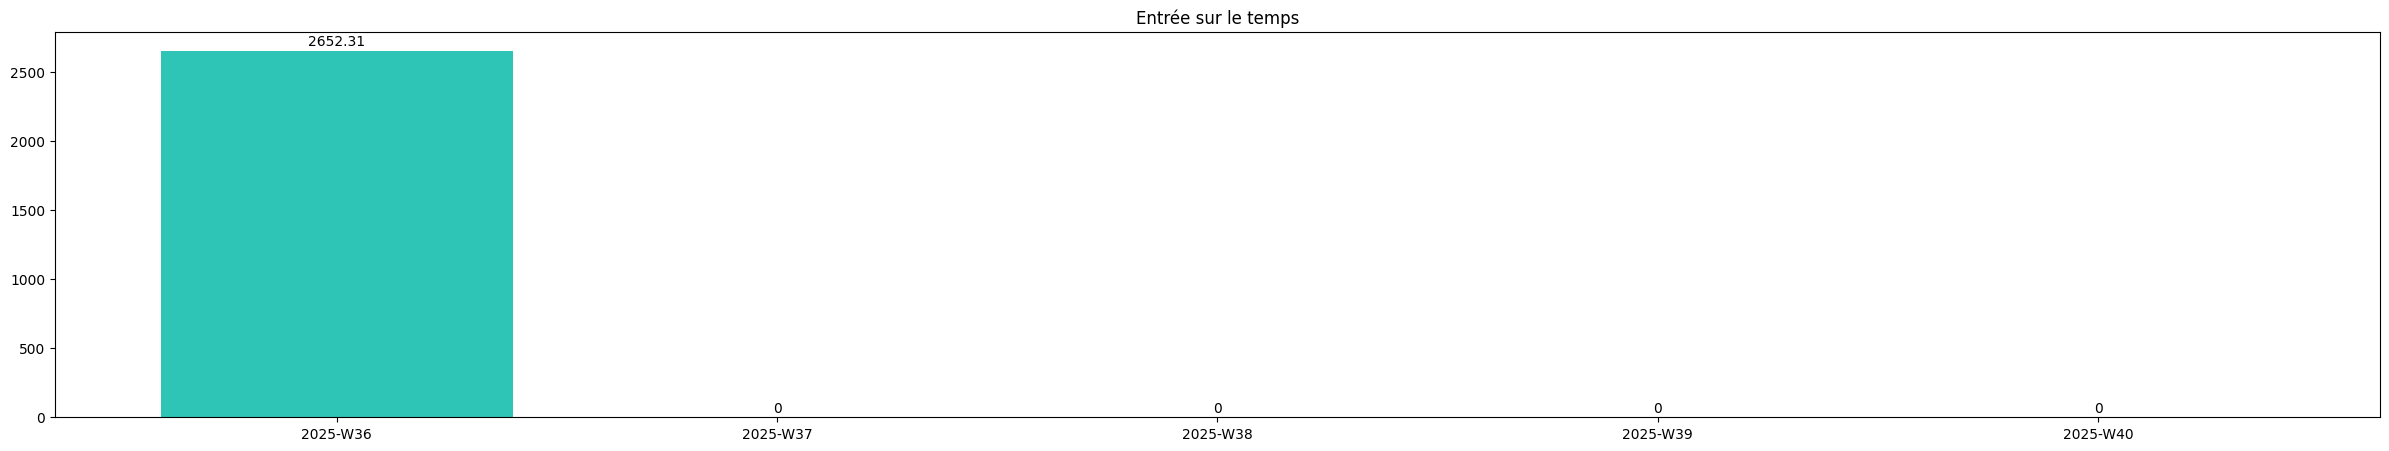

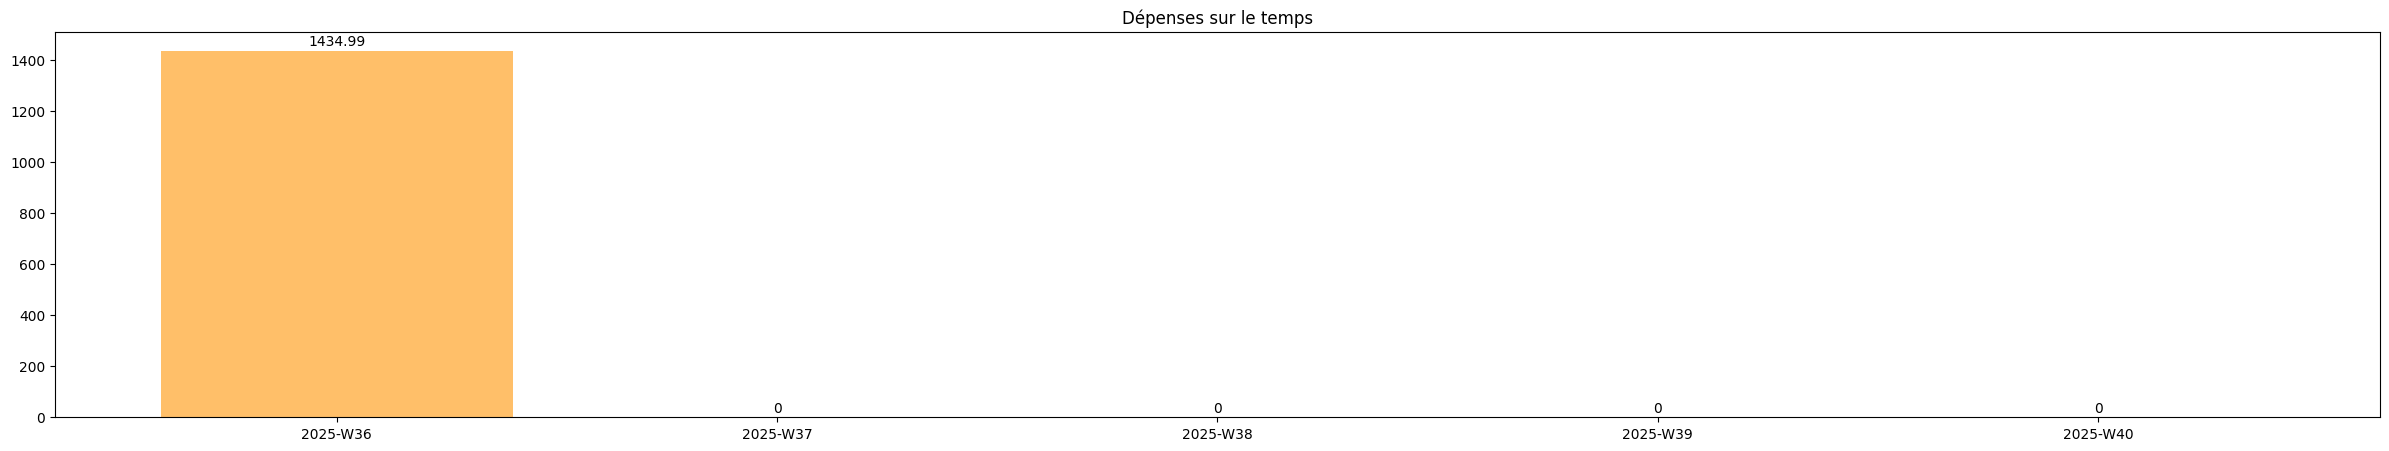

In [54]:
plot_entree_sur_temps(page_3_data, 'week', True)
plot_depenses_sur_temps(page_3_data, 'week', True)

## 📜 Page N°4

In [55]:
page_4_filter_period_start = month_start
page_4_filter_period_end = month_end


# Extracttion de données filtrées
page_4_data = data.copy()
page_4_data = page_4_data[
        (page_4_data['Date'] >= page_4_filter_period_start)
    &   (page_4_data['Date'] <= page_4_filter_period_end)
]

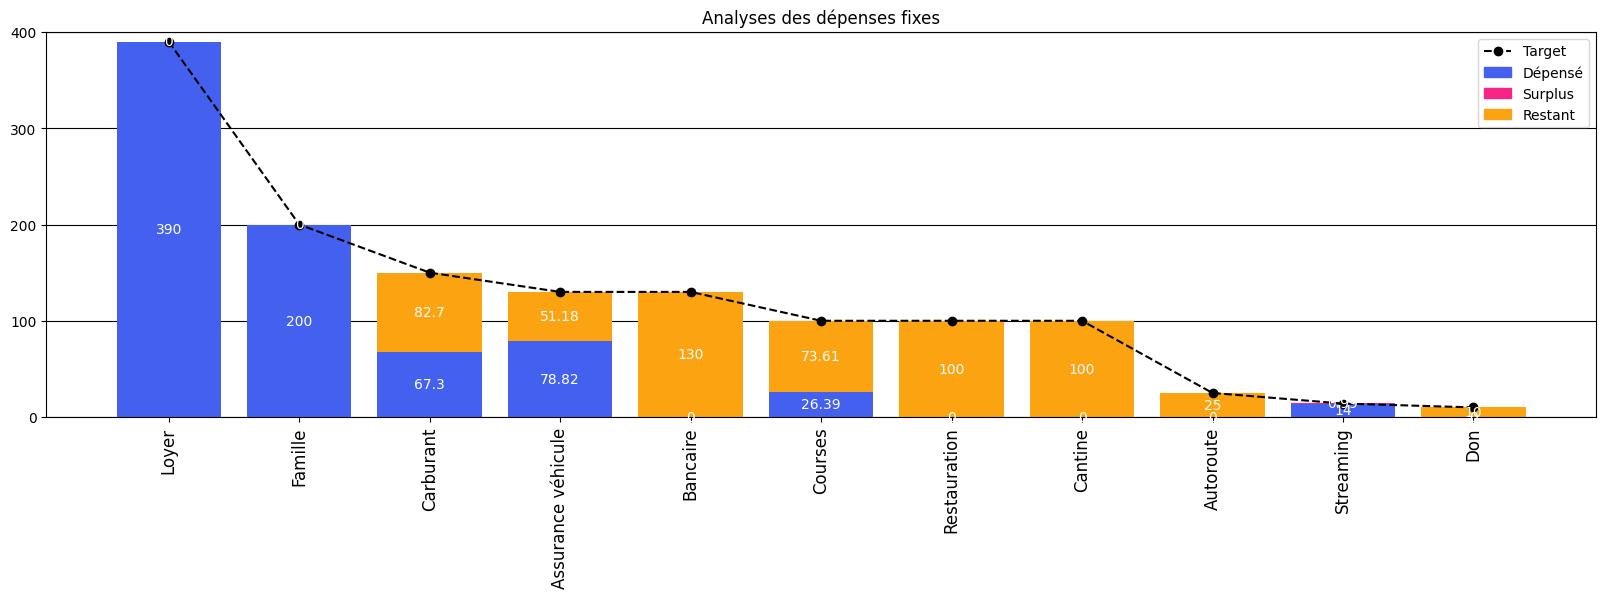

In [56]:
plot_target_comparaison(page_4_data)

# 🔮 Experiments